Look at distances

In [47]:
import igraph as ig
import pandas as pd
import numpy as np
import seaborn as sns
from compress_pickle import load, dump
from statistics import mean, median
from IPython.display import clear_output
from c_means_clustering import network_c_means
from copy import deepcopy
import itertools as it
import matplotlib.pyplot as plt
from math import log10

plt.style.use('bmh')

def open_pickle(file):
    with open(path+file, 'rb') as pickle_file:
        return load(path=pickle_file, compression='infer')

path = './files/'

regulome_network_edges = pd.read_csv(filepath_or_buffer=path+'/human_regulome_pd.gz', compression='infer')
regulome_network_edges = regulome_network_edges.astype({'ProteinAid': 'str', 'ProteinBid':'str'})

regulome_graph = ig.Graph.DataFrame(regulome_network_edges, directed=False, use_vids=False)
proteins = pd.concat([regulome_network_edges['ProteinAid'], regulome_network_edges['ProteinBid']]).unique()

clusters_dict = open_pickle("c_means_leiden_clusters.gz")
clusters_dict = {cluster_id: cluster for (cluster_id, cluster) in clusters_dict.items() if len(cluster) > 10}

In [ ]:
# Path lengths dictionary
with open(path+'path_lengths_dict.gz', 'rb') as file:
    path_lengths_dict = load(file, compression='infer')

In [71]:
# distances_results_dict = dict()
# distance_measures = ('edge_ratio', 'dist_sum', 'path_len')
# for measure in distance_measures:
#     distances_results_dict[measure] = network_c_means(regulome_graph, deepcopy(clusters_dict), 2, n_iter=1, optimize=True, distance_measure=measure, path_lengths=path_lengths_dict)
    
# distances_results_dict['edge_ratio'] = distances_results_dict['edge_rate']
# del distances_results_dict['edge_rate']

# with open(path+'c_means_distances.gz', 'wb') as file:
#     dump(distances_results_dict, file, compression='infer')

# del path_lengths_dict

distances_results_dict = open_pickle("c_means_distances.gz")

In [51]:
protein_edges = pd.concat([regulome_network_edges['ProteinAid'], regulome_network_edges['ProteinBid']]).value_counts()
most_connected_proteins = tuple(protein_edges.index[:5])
least_connected_proteins = tuple(protein_edges.index[-5:])

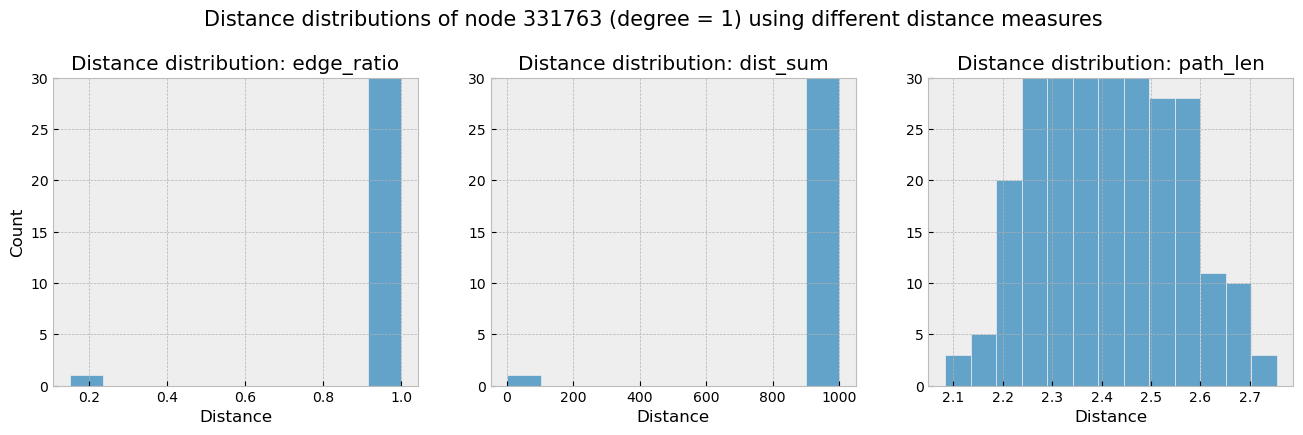

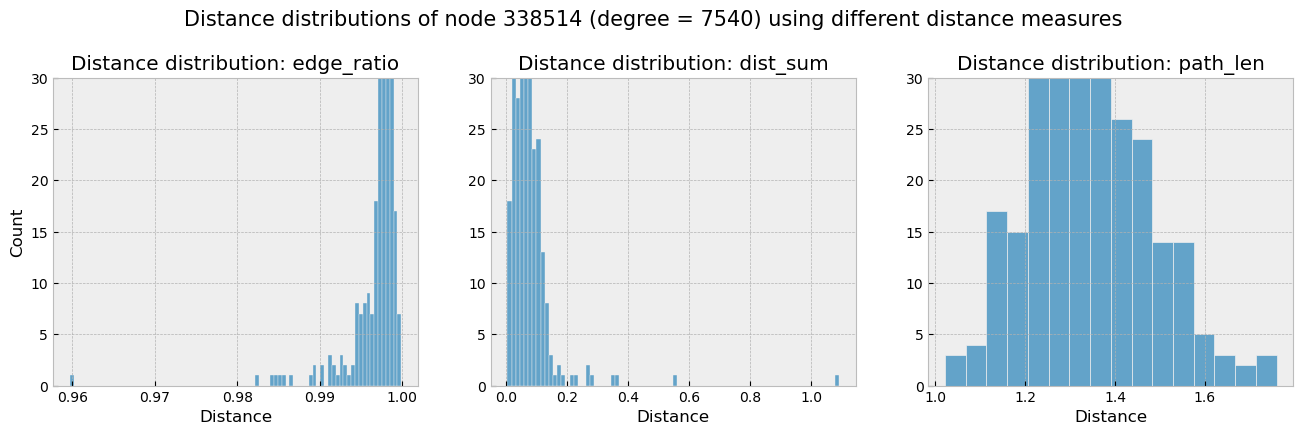

In [ ]:
# Distances of least connected
distance_measures = ('edge_ratio', 'dist_sum', 'path_len')
least_connected_node = least_connected_proteins[0]
most_connected_node = most_connected_proteins[0]

fig, axes = plt.subplots(1,3,figsize=[16,4])
title = fig.suptitle(f"Distance distributions of node {least_connected_node} (degree = 1) using different distance measures", fontsize=15, y=1.05)

for ax, measure in zip(axes, distance_measures):
    
    result = distances_results_dict[measure][3][least_connected_node]
    distances = [distance for distance in result.values()]
    # print(sorted(distances))
    sns.histplot(distances, ax=ax).set_ylim([0,30])
    ax.set_title(f"Distance distribution: {measure}")
    ax.set_xlabel("Distance")
    if measure != distance_measures[0]:
        ax.set(ylabel=None)

plt.savefig('./images/distance_distr_least_connected.png', dpi=fig.dpi, bbox_inches='tight',bbox_extra_artists=[title])

# Distances of most connected

fig, axes = plt.subplots(1,3,figsize=[16,4])

for ax, measure in zip(axes, distance_measures):
    
    result = distances_results_dict[measure][3][most_connected_node]
    distances = [distance for distance in result.values()]
    # print(sorted(distances))
    sns.histplot(distances, ax=ax).set_ylim([0, 30])
    ax.set_title(f"Distance distribution: {measure}")
    ax.set_xlabel("Distance")
    if measure != distance_measures[0]:
        ax.set(ylabel=None)

title = fig.suptitle(f"Distance distributions of node {most_connected_node} (degree = {regulome_graph.degree(most_connected_node)}) using different distance measures", fontsize=15, y=1.05)

plt.savefig('./images/distance_distr_most_connected.png', dpi=fig.dpi, bbox_inches='tight',bbox_extra_artists=[title])

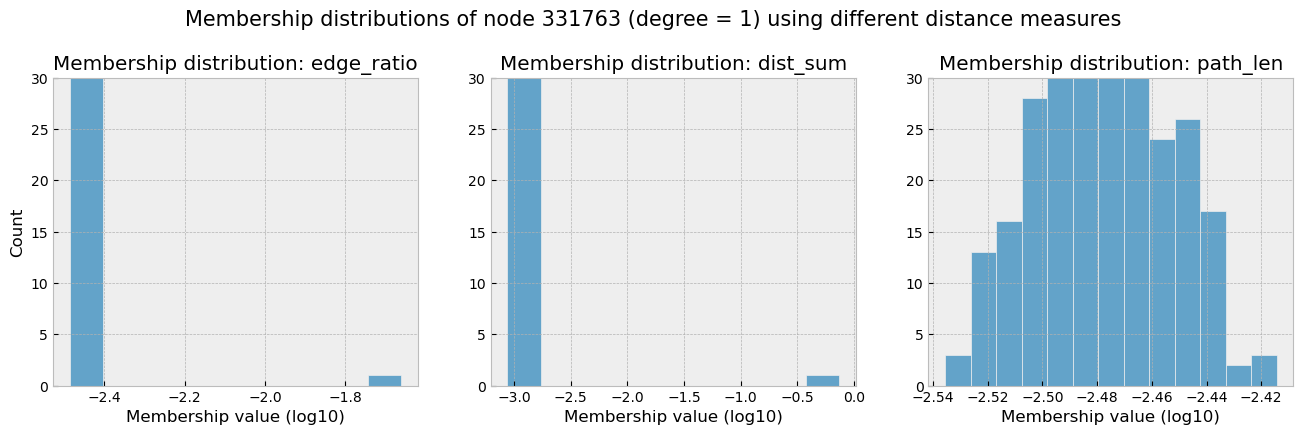

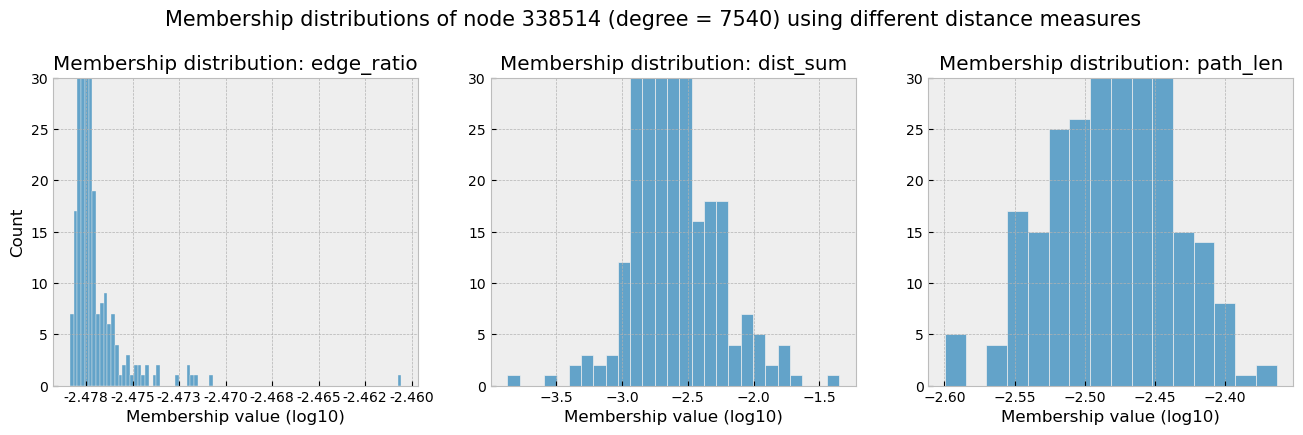

In [88]:
from matplotlib.ticker import FormatStrFormatter


# Mmeberhsip of least connected
distance_measures = ('edge_ratio', 'dist_sum', 'path_len')
least_connected_node = least_connected_proteins[0]
most_connected_node = most_connected_proteins[0]

fig, axes = plt.subplots(1,3,figsize=[16,4])
title = fig.suptitle(f"Membership distributions of node {least_connected_node} (degree = 1) using different distance measures", fontsize=15, y=1.05)

for ax, measure in zip(axes, distance_measures):
    result = distances_results_dict[measure][2][least_connected_node]
    memberships = [log10(membership) for membership in result.values()]
    # print(sorted(distances))
    sns.histplot(memberships, ax=ax).set_ylim([0,30])
    ax.set_title(f"Membership distribution: {measure}")
    ax.set_xlabel("Membership value (log10)")
    if measure != distance_measures[0]:
        ax.set(ylabel=None)

# Membership most connected
plt.savefig('./images/membership_distr_least_connected.png', dpi=fig.dpi, bbox_inches='tight',bbox_extra_artists=[title])

fig, axes = plt.subplots(1,3,figsize=[16,4])
title = fig.suptitle(f"Membership distributions of node {most_connected_node} (degree = {regulome_graph.degree(most_connected_node)}) using different distance measures", fontsize=15, y=1.05)

for ax, measure in zip(axes, distance_measures):
    result = distances_results_dict[measure][2][most_connected_node]
    memberships = [log10(membership) for membership in result.values()]
    # print(sorted(distances))
    sns.histplot(memberships, ax=ax).set_ylim([0,30])
    ax.set_title(f"Membership distribution: {measure}")
    ax.set_xlabel("Membership value (log10)")
    if measure != distance_measures[0]:
        ax.set(ylabel=None)
    else:
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))

plt.savefig('./images/membership_distr_most_connected.png', dpi=fig.dpi, bbox_inches='tight',bbox_extra_artists=[title])